In [1]:
import torch
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import html
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
nltk.download('stopwords')

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data_frame=pd.read_csv("C:\\Users\\HP\\OneDrive\\Desktop\\GRAD PROJ\\DataSet.csv")
# Assuming 'label' is the column with your target classes
class_distribution = data_frame['label'].value_counts()
# Print the distribution
print(class_distribution)
print(data_frame.shape)


label
0.0    581037
1.0    123908
Name: count, dtype: int64
(705069, 2)


C:\Users\HP\AppData\Local\Temp\ipykernel_9416\2181740126.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


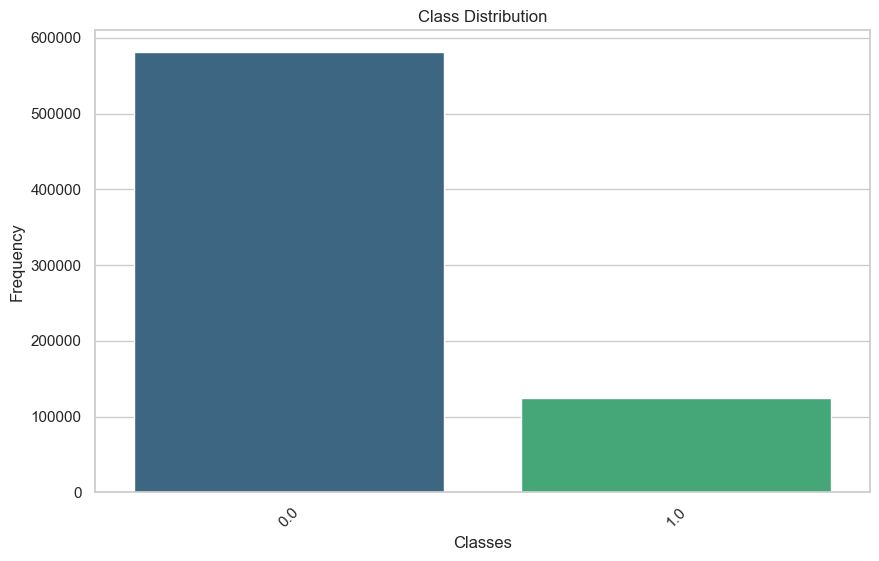

In [3]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution')  # Title of the plot
plt.xlabel('Classes')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks(rotation=45)  # Rotate the class names if needed

# Show the plot
plt.show()

In [4]:
# Splitting the data into two subsets: one for initial training and one for extra purposes
train_df, extra_df = train_test_split(data_frame,  random_state=42 ,train_size=0.1 )


In [5]:
# Separate majority and minority classes in the training dataframe
majority_class = train_df[train_df.label == 0]
minority_class = train_df[train_df.label == 1]

# Oversampling the minority class in the training dataset
minority_class_upsampled = resample(minority_class, 
                                    replace=True,     # sample with replacement
                                    n_samples=len(majority_class),    # to match majority class
                                    random_state=42) # reproducible results

# Combine majority class with upsampled minority class
balanced_train_df = pd.concat([majority_class, minority_class_upsampled])

# Shuffle the DataFrame to mix up the rows
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42)


In [6]:
# Save the balanced training dataset and the extra dataset to disk
balanced_train_df.to_csv("C:\\Users\\HP\\OneDrive\\Desktop\\GRAD PROJ\\balanced_train_DataSet2.csv", index=False)
extra_df.to_csv("C:\\Users\\HP\\OneDrive\\Desktop\\GRAD PROJ\\extra_DataSet2.csv", index=False)

In [2]:
df=pd.read_csv("C:\\Users\\HP\\OneDrive\\Desktop\\GRAD PROJ\\training_data.csv")
df=df.dropna()

(119943, 2)
label
1.0    59991
0.0    59952
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_9872\729645145.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


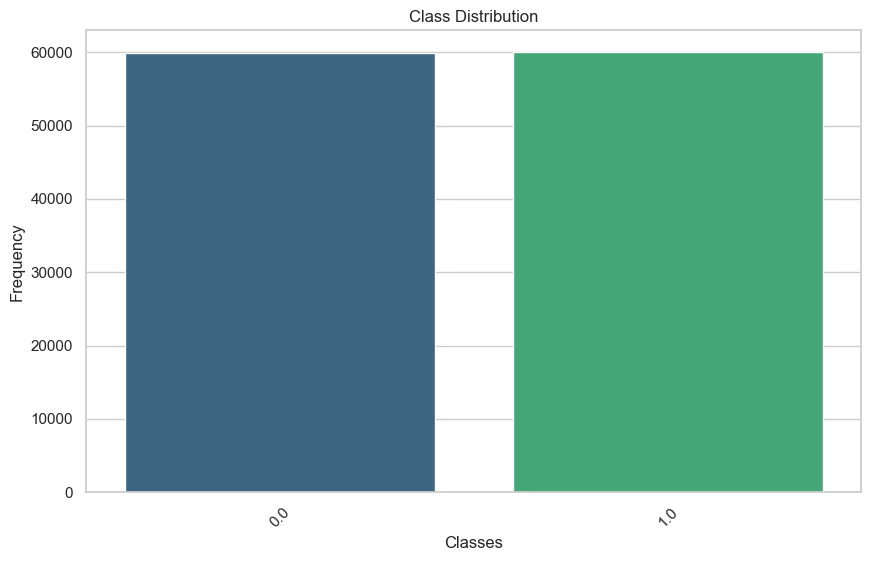

In [3]:
print(df.shape)


# Print the distribution
print(class_distribution)
class_distribution = df['label'].value_counts()

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution')  # Title of the plot
plt.xlabel('Classes')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks(rotation=45)  # Rotate the class names if needed

# Show the plot
plt.show()

In [ ]:
print(extra_df.shape)



# Print the distribution

class_distribution_extra_df = extra_df['label'].value_counts()
print(class_distribution_extra_df)
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.barplot(x=class_distribution_extra_df.index, y=class_distribution_extra_df.values, palette='viridis')
plt.title('Class Distribution for extra')  # Title of the plot
plt.xlabel('Classes')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks(rotation=45)  # Rotate the class names if needed

# Show the plot
plt.show()

In [5]:
#delete the url, usernames,hashtags
import neattext.functions as nfx
import html
def clean_text(text):
    
    if isinstance(text, float):
                text = str(text)
    text=nfx.remove_stopwords(text)
  #remove url

    text = html.unescape(text)
    text =re.sub(r'http\S+|www\S+|https\S+',' ',text)

    # Remove usernames
    text = re.sub(r'@\w+|\#\w+', '', text)
    #text = clean(text)
    return text

# Example usage:
# Assuming dd["text"] contains mixed data types including strings and possibly other types
#df["text"] = df["text"].apply(lambda x : clean_text(x))


In [6]:
# Dataset Class for Text Classification
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, text_preprocessing_fun=None):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_preprocessing_fun = text_preprocessing_fun if text_preprocessing_fun is not None else lambda x: x

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        text = self.text_preprocessing_fun(text)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )
        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:
def prepare_data_from_df(df, test_size=0.2, random_state=2022):
    # Clean and prepare text data
    df["text"] = df["text"].apply(clean_text)
    
    # Map labels to classes
    
    X=df.text.values
    y=df.label.values
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_val, y_train, y_val

In [8]:
def setup_cuda():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device
device=setup_cuda()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 2050


In [9]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [10]:
def process_df_and_get_dataloaders(df):
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    X_train, X_val, y_train, y_val = prepare_data_from_df(df)

    # Create Dataset and DataLoader for training and validation
    train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, 128, clean_text)
    val_dataset = TextClassificationDataset(X_val, y_val, tokenizer, 128, clean_text)

    batch_size = 64
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    # Total number of data points in the dataset
    total_data_points = len( train_dataset)

    # Batch size (specified when you created the DataLoader)
    batch_size = train_dataloader.batch_size

    # Calculate the number of batches
    num_batches = len(train_dataloader)

    print(f"Total data points: {total_data_points}")
    print(f"Batch size: {batch_size}")
    print(f"Number of batches: {num_batches}")

    # If you need the total number of data points from the DataLoader directly (for confirmation)
    total_points_from_loader = sum(1 for _ in train_dataloader) * batch_size
    # Adjust for the last batch if it might be smaller
    total_points_from_loader_adjusted = total_points_from_loader - batch_size + (total_data_points % batch_size or batch_size)
    print(f"Calculated total data points from DataLoader: {total_points_from_loader_adjusted}")
    # Total number of data points in the dataset
    total_data_points = len(val_dataset)

    # Batch size (specified when you created the DataLoader)
    batch_size = val_dataloader.batch_size

    # Calculate the number of batches
    num_batches = len(val_dataloader)

    print(f"Total data points: {total_data_points}")
    print(f"Batch size: {batch_size}")
    print(f"Number of batches: {num_batches}")

    # If you need the total number of data points from the DataLoader directly (for confirmation)
    total_points_from_loader = sum(1 for _ in val_dataloader) * batch_size
    # Adjust for the last batch if it might be smaller
    total_points_from_loader_adjusted = total_points_from_loader - batch_size + (total_data_points % batch_size or batch_size)
    print(f"Calculated total data points from DataLoader: {total_points_from_loader_adjusted}")

    return train_dataloader, val_dataloader

In [11]:
train_dataloader, val_dataloader = process_df_and_get_dataloaders(df)

Total data points: 95954
Batch size: 64
Number of batches: 1500
Calculated total data points from DataLoader: 95954
Total data points: 23989
Batch size: 64
Number of batches: 375
Calculated total data points from DataLoader: 23989


In [12]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False, version="bert"):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("bert-base-uncased") 
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: total: 0 ns
Wall time: 585 ms


In [13]:
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.optim import SparseAdam, Adam
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(params=list(bert_classifier.parameters()),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [14]:
import random
import time
import torch
import torch.nn as nn
from transformers import AutoModel

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Lists to store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            
            # Load batch to GPU
            b_input_ids = batch['input_ids'].to(device)
            b_attn_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
            batch_counts +=1
            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")
    return train_losses, val_losses, val_accuracies



def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        # Load batch to GPU
        b_input_ids = batch['input_ids'].to(device)
        b_attn_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)


        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [15]:
# Set the seed for reproducibility
set_seed(42) 

# Initialize the model, optimizer, and scheduler
bert_classifier, optimizer, scheduler = initialize_model()

# Train the model and save the metrics
train_losses, val_losses, val_accuracies = train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.565756   |     -      |     -     |  345.10  
   1    |   40    |   0.392687   |     -      |     -     |  327.90  
   1    |   60    |   0.356499   |     -      |     -     |  325.61  
   1    |   80    |   0.338413   |     -      |     -     |  324.84  
   1    |   100   |   0.375877   |     -      |     -     |  327.08  
   1    |   120   |   0.350503   |     -      |     -     |  328.22  
   1    |   140   |   0.361145   |     -      |     -     |  329.04  
   1    |   160   |   0.339126   |     -      |     -     |  344.89  
   1    |   180   |   0.345948   |     -      |     -     |  332.77  
   1    |   200   |   0.338881   |     -      |     -     |  327.39  
   1    |   220   |   0.295665   |     -      |     -     |  327.87  
   1    |   240   |   0.341220   |     -      |     -     |  330.58  


In [16]:
def save_model(model, optimizer, scheduler, save_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, save_path)

# Example usage
save_model(bert_classifier, optimizer, scheduler, 'C:\\Users\\HP\\OneDrive\\Desktop\\GRAD PROJ\\cyber_ENmodel_checkpoint.pth')


In [26]:
# Load the testing dataset
test_df = pd.read_csv("C:\\Users\\HP\\OneDrive\\Desktop\\GRAD PROJ\\extra_data.csv")
# Sample a fixed number of rows (e.g., 100 rows) from your test DataFrame randomly
test_df = test_df.sample(n=12000, random_state=42)  # Adjust n as needed

test_df = test_df.dropna()
print(test_df.shape)

# Preprocess the text data in the test dataset
test_df["text"] = test_df["text"].apply(clean_text)

# Tokenize and create a DataLoader for the test data
def prepare_data_for_testing(df, tokenizer, max_len=128):
    texts = df.text.values
    labels = df.label.values  # Make sure your testing data also has labels for evaluation

    # Create Dataset
    test_dataset = TextClassificationDataset(texts, labels, tokenizer, max_len, clean_text)

    # Create DataLoader
    test_dataloader = DataLoader(test_dataset, batch_size=64)  # Adjust batch size as necessary
    total_data_points = len( test_dataset)

    # Batch size (specified when you created the DataLoader)
    batch_size =test_dataloader.batch_size

        # Calculate the number of batchesq
    num_batches = len(test_dataloader)

    print(f"Total data points: {total_data_points}")
    print(f"Batch size: {batch_size}")
    print(f"Number of batches: {num_batches}")

        # If you need the total number of data points from the DataLoader directly (for confirmation)
    total_points_from_loader = sum(1 for _ in test_dataloader) * batch_size
        # Adjust for the last batch if it might be smaller
    total_points_from_loader_adjusted = total_points_from_loader - batch_size + (total_data_points % batch_size or batch_size)
    print(f"Calculated total data points from DataLoader: {total_points_from_loader_adjusted}")
        # Total number of data points in the dataset

    return test_dataloader

test_dataloader = prepare_data_for_testing(test_df, tokenizer)


(11998, 2)
Total data points: 11998
Batch size: 64
Number of batches: 188
Calculated total data points from DataLoader: 11998


label
0.0    6077
1.0    5921
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_9872\1785527301.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution_test.index, y=class_distribution_test.values, palette='viridis')


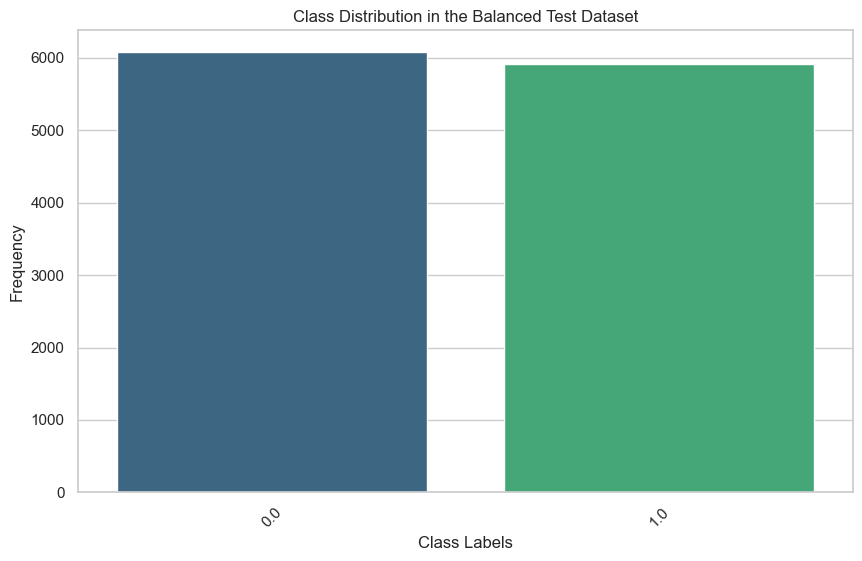

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns


class_distribution_test = test_df['label'].value_counts()
print(class_distribution_test)
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size
class_distribution = test_df['label'].value_counts()
sns.barplot(x=class_distribution_test.index, y=class_distribution_test.values, palette='viridis')

# Adding title and labels to the plot
plt.title('Class Distribution in the Balanced Test Dataset')
plt.xlabel('Class Labels')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks(rotation=45)  # Rotate the class names if needed

# Show the plot
plt.show()


In [29]:
def evaluate_on_test(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_accuracy = 0

    # Tracking variables
    predictions , true_labels = [], []

    for batch in test_dataloader:
        # Add batch to GPU
        batch = tuple(t.to('cuda') for t in batch.values())
        b_input_ids, b_attn_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, b_attn_mask)

        logits = outputs
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Store predictions and true labels
        predictions.extend(np.argmax(logits, axis=1).flatten())
        true_labels.extend(label_ids.flatten())

    # Calculate the accuracy for this batch of test sentences
    tmp_test_accuracy = np.mean(np.array(predictions) == np.array(true_labels))

    print(f'Test Accuracy: {tmp_test_accuracy}')

    return predictions, true_labels , tmp_test_accuracy

# Evaluate the model
predictions, true_labels, test_accuracy = evaluate_on_test(bert_classifier, test_dataloader, device)

Test Accuracy: 0.9160693448908152


Validation Accuracies per Epoch: [90.18647798742138, 90.91564465408806, 91.40400943396227, 91.25400943396227]


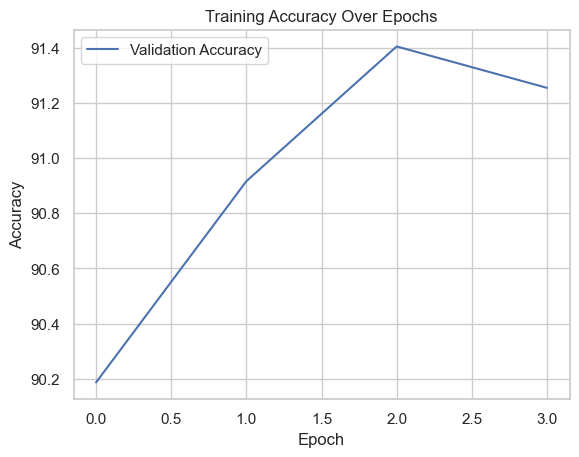

In [31]:
# Print or plot training accuracy
# Assuming you have stored training accuracies in `val_accuracies`
print("Validation Accuracies per Epoch:", val_accuracies)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.93      0.89      0.91     10062
           1       0.90      0.93      0.92      9933

    accuracy                           0.91     19995
   macro avg       0.92      0.91      0.91     19995
weighted avg       0.92      0.91      0.91     19995

[[9004 1058]
 [ 652 9281]]


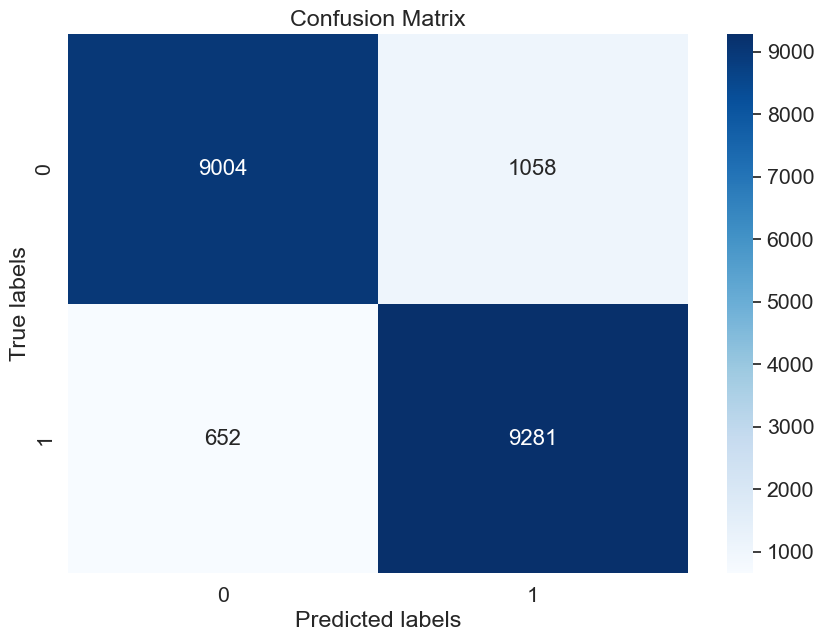

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming `true_labels` and `predictions` are already defined
conf_matrix = confusion_matrix(true_labels, predictions)

# Plotting using Seaborn
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues")  # fmt='g' avoids scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


0.9160693448908152


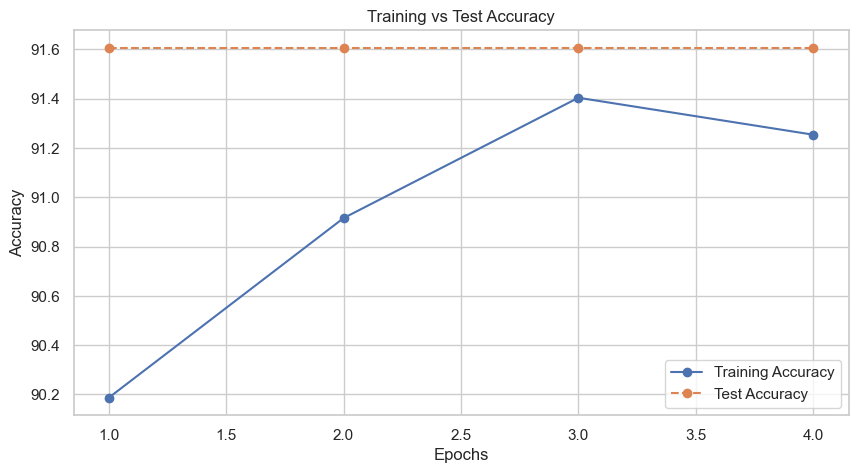

In [35]:
import matplotlib.pyplot as plt
print(test_accuracy)
# Generate a list of epochs based on the length of your training accuracies
epochs = list(range(1, len(val_accuracies) + 1))
test_accuracies = [test_accuracy*100] * len(val_accuracies)

plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracies, label='val Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('val vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [37]:

def load_model(model_path):
    # Create a new model instance
    model = BertClassifier()
    # Load the saved state
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

model_path = 'C:\\Users\\HP\\OneDrive\\Desktop\\GRAD PROJ\\cyber_ENmodel_checkpoint.pth'
model = load_model(model_path)
model.eval()  # Set the model to evaluation mode



BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(model, dataloader, device):
    true_labels = []
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    
    return accuracy, precision, recall, f1

# Assuming you have a dataloader for your training data and a device setup
model = BertClassifier()
checkpoint = torch.load('C:\\Users\\HP\\OneDrive\\Desktop\\GRAD PROJ\\cyber_ENmodel_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)  # Move model to the appropriate device

train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(model, train_dataloader, device)
print(f"Training Metrics:\nAccuracy: {train_accuracy * 100:.2f}%\nPrecision: {train_precision:.2f}\nRecall: {train_recall:.2f}\nF1 Score: {train_f1:.2f}")


Training Metrics:
Accuracy: 98.81%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


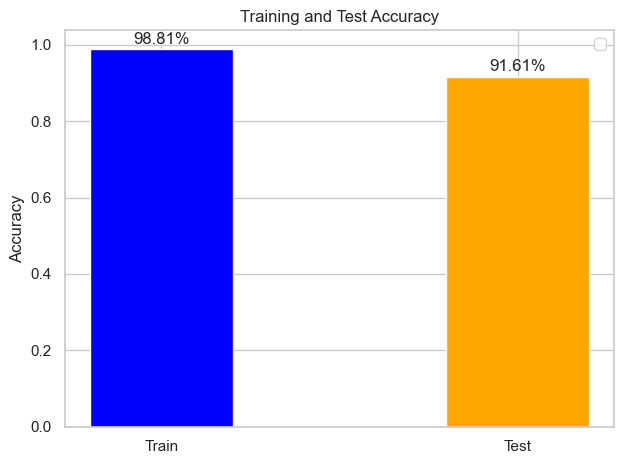

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Define the accuracies to plot
accuracies = ['Train',  'Test']
accuracy_values = [train_accuracy,  test_accuracy]

# Define the x-axis positions
x = np.arange(len(accuracies))

fig, ax = plt.subplots()

# Plot the accuracies
rects = ax.bar(x, accuracy_values, width=0.4, color=['blue', 'orange'])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Training and Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(accuracies)
ax.legend()

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height*100:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()

plt.show()


In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

def save_model(model, optimizer, scheduler, save_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, save_path)

def cross_val_evaluate(ModelClass, dataset, k=4):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(dataset.texts, dataset.labels)):
        print(f'Fold {fold + 1}/{k}')
        
        # Prepare the data for this fold
        train_texts = [dataset.texts[i] for i in train_idx]
        train_labels = [dataset.labels[i] for i in train_idx]
        val_texts = [dataset.texts[i] for i in val_idx]
        val_labels = [dataset.labels[i] for i in val_idx]
        
        # Create datasets and dataloaders
        train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, 128, clean_text)
        val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, 128, clean_text)
        
        train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=64)
        
        # Initialize the model, optimizer, and scheduler
        model = ModelClass()
        optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
        total_steps = len(train_dataloader) * 4
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        
        model.to(device)
        
        # Train the model
        train_losses, val_losses, val_accuracies = train(model, train_dataloader, val_dataloader, epochs=3, evaluation=True)
        
        # Validate the model
        val_accuracy, _, _, _ = calculate_metrics(model, val_dataloader, device)
        accuracies.append(val_accuracy)
        print(f'Fold {fold + 1} Validation Accuracy: {val_accuracy * 100:.2f}%')
        
        # Save the model for this fold
        model_save_path = f'bert_classifier_fold_{fold + 1}.pth'
        save_model(model, optimizer, scheduler, model_save_path)
        print(f'Model saved for fold {fold + 1} at {model_save_path}')
    
    # Calculate and print the average accuracy
    avg_accuracy = np.mean(accuracies)
    print(f'Average Cross-Validation Accuracy: {avg_accuracy * 100:.2f}%')

# Assuming `df` is your DataFrame and `device` is set up
df["text"] = df["text"].apply(clean_text)
texts = df["text"].values
labels = df["label"].values

# Create the initial dataset
dataset = TextClassificationDataset(texts, labels, tokenizer, 128, clean_text)

# Perform cross-validation
cross_val_evaluate(BertClassifier, dataset, k=5)


Fold 1/5


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
